# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [437]:
import pickle
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.image as image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import sklearn.metrics as metrics
import itertools
import cv2
from skimage import exposure, transform, filters

In [438]:
# Load pickled data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
sizes_train, sizes_test = train['sizes'], test['sizes']
coords_train, coords_test = train['coords'], test['coords']

print("Data loaded !")

Data loaded !


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [439]:
# Counting of the train set
count_train = np.zeros((max(y_train)+1))
for label in y_train:
    count_train[label] += 1
        
# Counting of the test set
count_test = np.zeros((max(y_test)+1))
for label in y_test:
    count_test[label] += 1

In [440]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len([x for x in count_train if x != 0])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [441]:
# Load labels 
with open('signnames.csv', mode='r') as f:
    # Skip header
    f.readline()
    
    # Convert to list
    reader = csv.reader(f)   
    signnames = [rows[1] for rows in reader]

In [442]:
def plot_hist(count, signnames, title = 'Histogram'):
    """Plots a bar plot of the list of counts considering the corresponding list of labels.
    A title may be provided optionally."""
    n_classes = len(signnames)
    fig = plt.subplots(1, 1, figsize=(10, 4))
    plt.bar(range(n_classes),count, tick_label = signnames)
    plt.xticks(rotation = 'vertical')
    plt.xlim((0, n_classes))
    plt.title(title)
    plt.grid()
    plt.show()

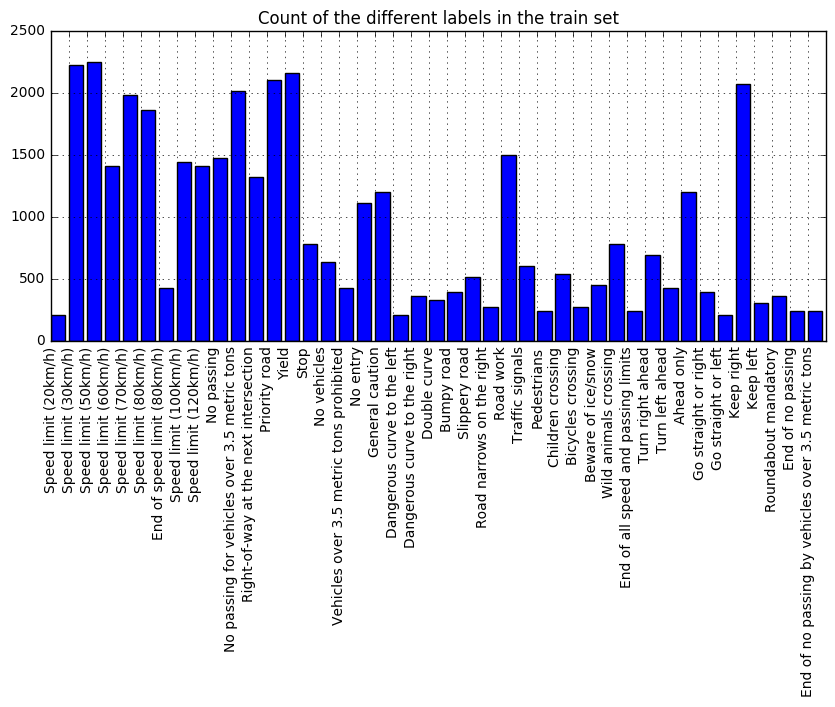

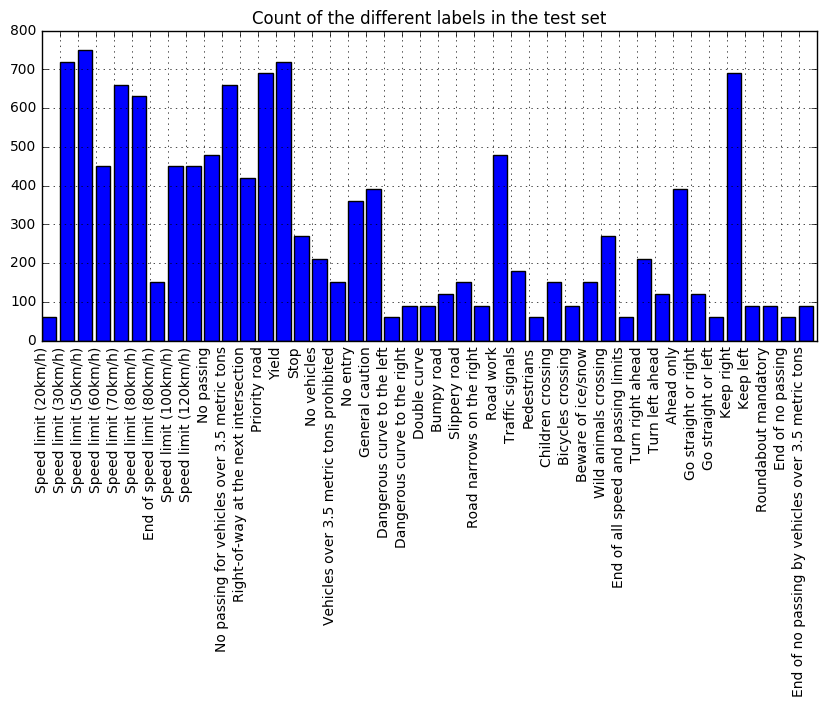

In [444]:
# Count bar plots - train
plot_hist(count_train, signnames, title = 'Count of the different labels in the train set')
# Count bar plots - test
plot_hist(count_test, signnames, title = 'Count of the different labels in the test set')

In [445]:
def plot_sign(sign, label, box, ax, cmap):
    """Plots the image of a sign sign whose image data is provided as an array in the sign parameter. The
    string label is used as a title of the image and the box coordinates [x1 y1 x2 y2] are used to plot
    a bounding box around the sign. The plot is done in the ax object provided to the function and the
    color map can be adapted in case of a grayscale image."""
    ax.imshow(sign, cmap)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    p = patch.Rectangle(box[0:2], box[2]-box[0], box[3]-box[1], axes = ax, fill = False, edgecolor = 'green')
    ax.add_patch(p)

In [448]:
def plot_sign_array(X_data, y_data, coords_data = None, sizes_data = None, n_height = 5, n_width = 4, indexes = None, cmap = None):
    """Creates a grid of subplots of size [n_width, n_height] in which signs are plotted using the provided
    data. The images to be plotted are drawn randomly from the provided set if indexes is set to None. The
    color map can be adapted in case of grayscale images."""
    # Grid of subplots
    f, axarr = plt.subplots(n_height, n_width, figsize = (n_width*3,n_height*2))
    i = 0    
    
    # Iterate over each subplot
    for row in axarr:
        for ax in row:
            
            # Extract index of image to be plotted
            if indexes == None:
                index = random.randint(0, len(y_data)-1)
            else:
                index = indexes[i]
            
            # Process data and plot image
            label = signnames[y_data[index]]
            if coords_data != None:
                coords = np.array(coords_data[index])
                size = np.array(sizes_data[index])
                box = X_data[0].shape[0]*coords.astype(np.int)/np.concatenate((size, size))
                plot_sign(X_data[index], label, box, ax, cmap)
            else:
                plot_sign(X_data[index], label, [0,0,0,0], ax, cmap)
            i += 1;
    plt.show()

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


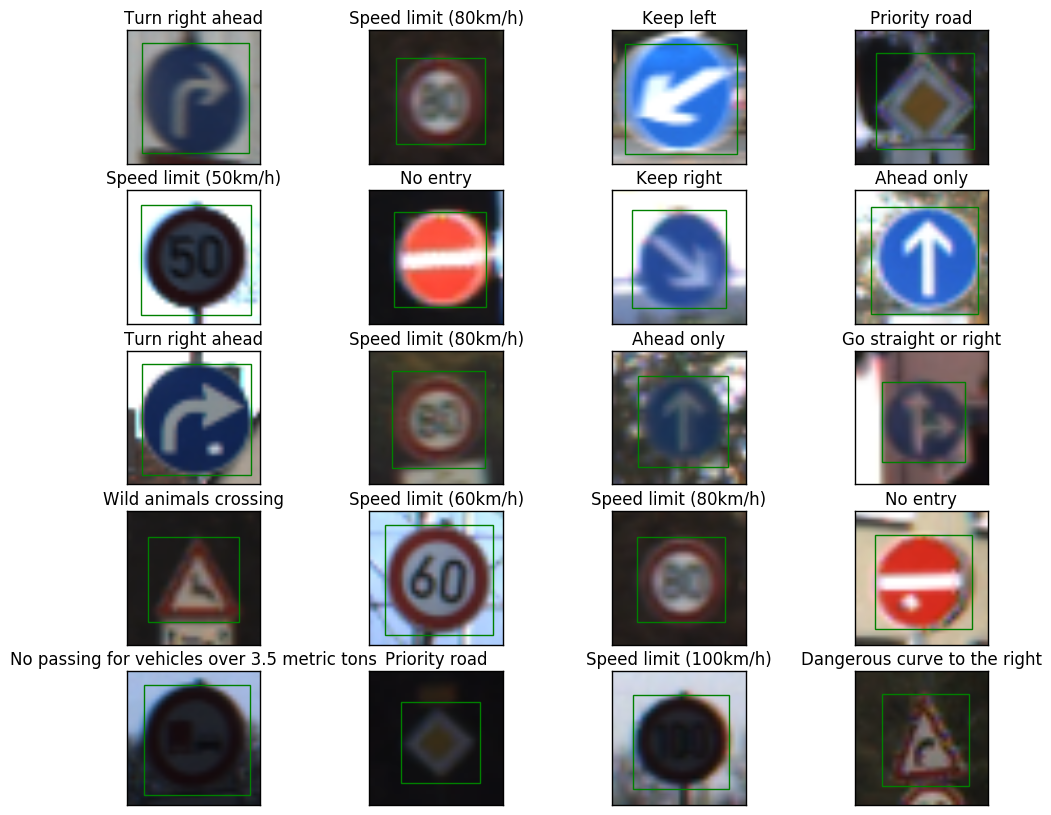

In [450]:
plot_sign_array(X_test, y_test, coords_test, sizes_test)

The amount of images per label is first counted in the training and the test set that are provided. It is observed that although all classes are present in the data sets, some classes are much more present than other. This may result in a neural network that favorizes classes present in greater number in the training data, since classes which are less present have a smaller influence on the cost. Data augmentation methods should be considered in the present case in order to equilibrate the data set better. 

Secondly, the data set is plotted as a grid of randomly sampled input images with the corresponding label. The bounding boxes provided in the pickled sets are plotted aswell. It is observed that the signs are well centered in the images and, generally, not cut off by the borders of the images. Some signs suffer quite a lot from pixelisation due to the resizing and some signs are very dark. Some signs are also very dark, which means some histogram equalisation might be useful, before the signs are fed to the model.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
def normalize_image(image_data):
    """Normalizes the data range of an image from an initial range of [0, 255] to a range of [0, 1]"""
    # Input mapping
    M = 255
    m = 0
    
    # Output mapping
    a = 1
    b = 0
    
    # Apply mapping
    return (image_data.astype(np.float32) - m)*(a - b)/(M - m)

def extract_Y_channel(image_data):
    """Converts an input image with three channels in RGB domain to YUV domain. 
    The Y component is then extract and returned."""
    n_images = len(image_data)
    image_out = np.zeros((n_images, image_data.shape[1], image_data.shape[2]))
    for i in range(n_images):
        image_yuv = cv2.cvtColor(image_data[i], cv2.COLOR_RGB2YUV)
        image_out[i] = image_yuv[:,:,0]
    return image_out

def equalize_histogram(image_data):
    """Applies Constrast Limitted Adaptive Histogram Equalisation to the input image.
    This allows to improve the constrast locally in the image. Hence, darker spots of the image
    become brighter and conversely for lighter spots. Resulting images have more pronounced features."""
    n_images = len(image_data)
    for i in range(n_images):
        image_data[i] = exposure.equalize_adapthist(image_data[i])  
    return image_data

def preprocess(image_data):
    """Preprocesses the images by first normalizing the images and equalizing their histogram in order to improve
    the features of very dark or very bright images. The Y-channel is then extracted,
    as the LeCunn paper suggested better classification results were obtained considering this
    channel only."""
    image_data = normalize_image(image_data)
    image_data = equalize_histogram(image_data)
    image_data = extract_Y_channel(image_data)
    return image_data

In [12]:
# Pre-process input 
X_train_pre = preprocess(X_train)
X_test_pre  = preprocess(X_test)

# Pre-process output
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_pre = encoder.transform(y_train)
y_test_pre  = encoder.transform(y_test)
y_train_pre = y_train_pre.astype(np.float32)
y_test_pre  = y_test_pre.astype(np.float32)

print("Data processed !")

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


Data processed !


C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


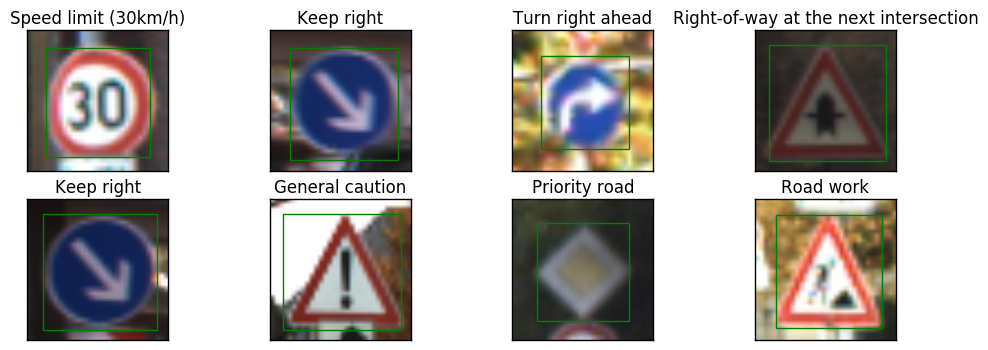

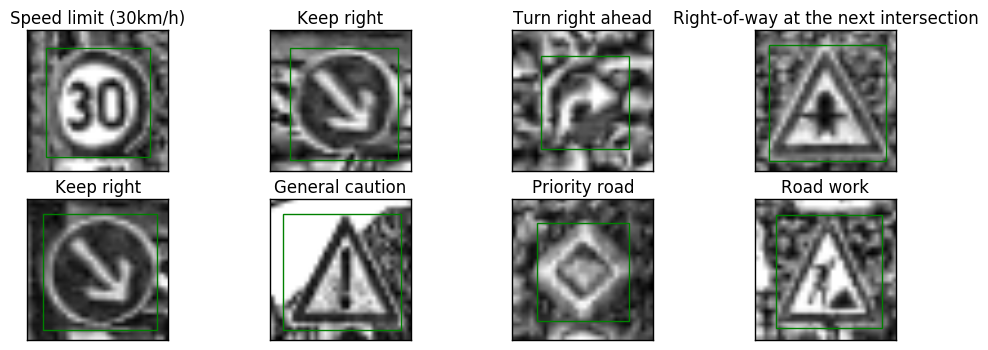

In [13]:
plot_sign_array(X_test, y_test, coords_test, sizes_test, 2, 4, range(1,9))
plot_sign_array(X_test_pre, y_test, coords_test, sizes_test, 2, 4, range(1,9), cmap = 'gray')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

**Image preprocessing**

Firstly, the input pixel values are normalized from a range of [0, 255] to a range of [0, 1]. This makes the optimisation problem easier to solve, as it is well-posed.

Secondly, it is observed that several images in the set are either very bright or very dark. Therefore, an histogram equalisation pass is realised that should adjust the brightness of all images. This is done locally using a Constrast Limitted Adaptive Histogram Equalisation algorithm, which has the added benefit of enhancing the local constrast in an image. This should result in more pronounced features that will, therefore, be easier to classify with the model.

Finally, the image is transformed to the YUV color space and only the Y channel is kept. This means that the model will use a grey scale input image, which allows for simpler models. The decrease in the number weights reduces the time needed for training and the risk of overfitting. This modificiation was motivated by the LeCunn paper, which shows that improved classification performance is obtained when considering only this Y channel.

**Label preprocessing**

The associated labels are transformed to one-hot representation and converted to float-valued vectors. This last step makes them usable by the cross-validation function in Tensorflow, where they are multiplied by other float values

In [240]:
def complete_y(y_flip, number, label):
    y_flip = np.append(y_flip, np.full((number), label, dtype = int))
    return y_flip

In [281]:
def data_flipping(X, y):
    
    # Horizontal flip
    horizontal_flip = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    
    # Vertical flip
    vertical_flip = np.array([1, 5, 12, 15, 17])
    
    # Double flip
    double_flip = np.array([32, 40])
    
    # Cross flip
    cross_flip = np.array([[19, 20], 
                           [20, 19],
                           [33, 34], 
                           [34, 33], 
                           [36, 37], 
                           [38, 39],        
                           [37, 36], 
                           [39, 38]])
    n_classes = 43
    
    # Initialisation of new list
    X_flip = np.empty([0, X.shape[1], X.shape[2]], dtype = X.dtype)
    y_flip = np.empty([0], dtype = y.dtype)
    
    for c in range(n_classes):
        
        # Unmodified data
        X_flip = np.append(X_flip, X[y == c], axis = 0)
        n =  X_flip.shape[0] - y_flip.shape[0]
        y_flip = complete_y(y_flip, n, c)
        
        # Horizontal flip
        if c in horizontal_flip:
            X_flip = np.append(X_flip, X[y == c][:, :, ::-1], axis = 0)
            n_hori = X_flip.shape[0] - y_flip.shape[0]
            y_flip = complete_y(y_flip, n_hori, c)
        
        # Vertical flip
        if c in vertical_flip:
            X_flip = np.append(X_flip, X[y == c][:, ::-1, :], axis = 0) 
            n_verti = X_flip.shape[0] - y_flip.shape[0]
            y_flip = complete_y(y_flip, n_verti, c)
        
        # Double flip
        if c in double_flip:
            X_flip = np.append(X_flip, X[y == c][:, ::-1, ::-1], axis = 0)  
            n_double = X_flip.shape[0] - y_flip.shape[0]
            y_flip = complete_y(y_flip, n_double, c)
        
        # Cross flip
        if c in cross_flip[:, 0]:   
            flip_class = cross_flip[cross_flip[:, 0] == c][0][1]
            X_flip = np.append(X_flip, X[y == flip_class][:, :, ::-1], axis = 0) 
            n_cross = X_flip.shape[0] - y_flip.shape[0]
            y_flip = complete_y(y_flip, n_cross, c)
        
    return (X_flip, y_flip)

(63538, 32, 32)


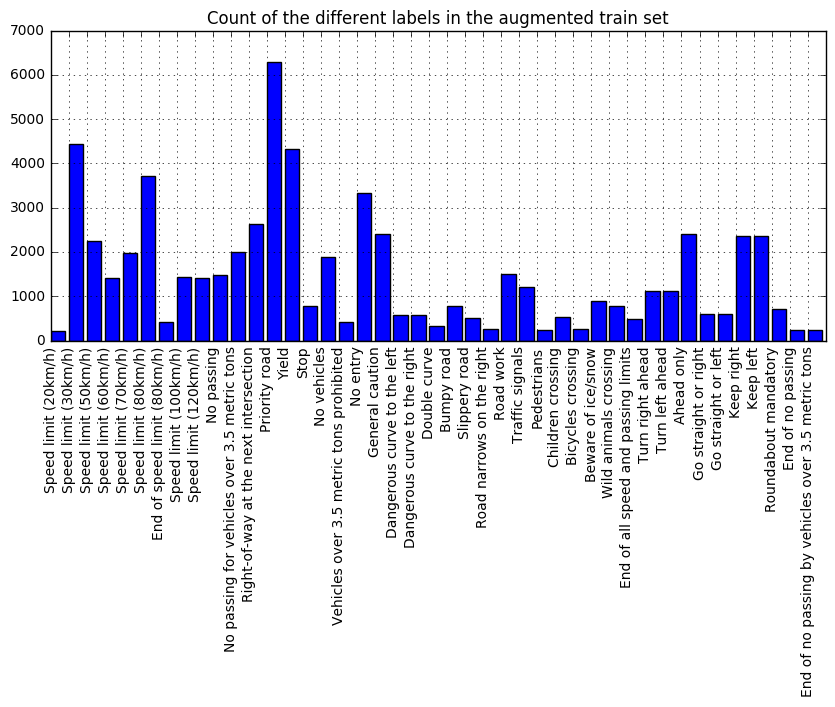

In [282]:
# Data flipping
X_train_aug, y_train_aug = data_flipping(X_train_pre, y_train)
print(X_train_aug.shape)

# Count of the new data
count_train_aug = np.zeros(43)
for label in y_train_aug:
    count_train_aug[label] += 1

# Plot new histogram
plot_hist(count_train_aug, signnames, title = 'Count of the different labels in the augmented train set')
y_train_aug = encoder.transform(y_train_aug)
y_train_aug = y_train_aug.astype(np.float32)

In [283]:
def fast_warp(image_data, transf, mode = 'edge'):
    """Proposed by Florian muellerklein"""
    out_shape = image_data.shape
    return transform._warps_cy._warp_fast(image_data,  transf.params, output_shape = out_shape, mode = mode)

def batch_augmentation(X, y, batch_size, augmentation = True):
    # Settings
    n = X.shape[0]
    x_translation_bounds = np.array([-2, 2])
    y_translation_bounds = np.array([-2, 2])
    rotation_bounds      = np.array([-5, 5])
    scale_bounds         = np.array([1, 1.1])
    shear_bounds         = np.array([-1, 1])    
    
    # Shuffling
    X, y = shuffle(X, y)
    output_x = []
    output_y = []
    
    for offset in range(0, n, batch_size):
        
        # Slicing
        batch_x, batch_y = X[offset:offset+batch_size], y[offset:offset+batch_size]
        
        if augmentation:
            l = batch_x.shape[0]

            # Translation
            x_translation = np.random.randint(x_translation_bounds[0], x_translation_bounds[1], l) 
            y_translation = np.random.randint(y_translation_bounds[0], y_translation_bounds[1], l)

            # Rotation
            rotation = np.random.uniform(rotation_bounds[0], rotation_bounds[1], l)

            # Scaling
            scale = np.random.uniform(scale_bounds[0], scale_bounds[1], l)

            # Shearing
            shear = np.random.uniform(shear_bounds[0], shear_bounds[1], l)

            # Transformation
            mid_point = np.array(batch_x.shape[1:3])/2.0
            transf_center = transform.SimilarityTransform(translation = -mid_point)
            transf_uncenter = transform.SimilarityTransform(translation = mid_point)

            # Apply transformation
            for i in range(batch_x.shape[0]):
                # Augmentation transformation is unique for each image
                transf_aug = transform.AffineTransform(translation = (x_translation[i], y_translation[i]),
                                                       rotation = np.deg2rad(rotation[i]),
                                                       scale = (1/scale[i], 1/scale[i]),
                                                       shear = np.deg2rad(shear[i]))
                transf = transf_center + transf_aug + transf_uncenter
                batch_x[i] = fast_warp(batch_x[i].reshape((32,32)), transf)
        
        # Storage
        output_x.append(batch_x)
        output_y.append(batch_y)
        
    # Return list of batches
    return output_x, output_y

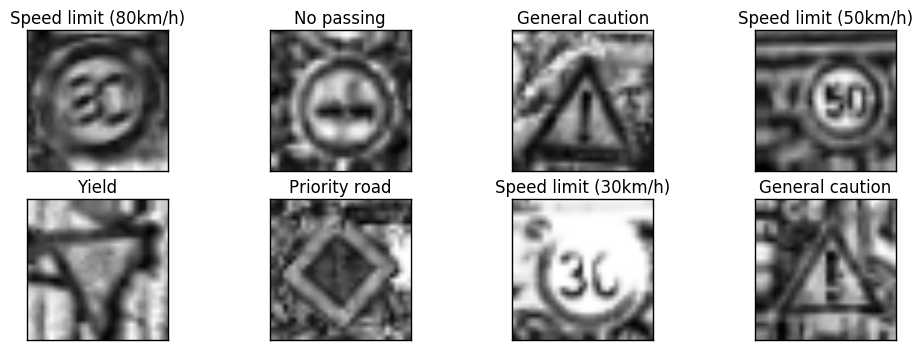

In [284]:
# Data warping
X_test, y_test = batch_augmentation(X_train_aug, y_train_aug, 9)
# Plot of the sign
plot_sign_array(X_test[0], np.argmax(y_test[0], 1), n_height = 2, n_width = 4, indexes = range(1,9), cmap = 'gray')

In [18]:
# Split training data in train and validation set
X_train_aug, X_valid_aug, y_train_aug, y_valid_aug = train_test_split(
    X_train_aug,
    y_train_aug,
    test_size=0.2,
    stratify = y_train_aug)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Several data augmentation routines were implemented to augment the data set and decrease the risk of overfitting of the model during its training. A first part of this augmentation is done offline, while second part is done during the training.

**Data flipping**

Firstly, it was observed that flipping some of the signs would result in images that were valid data for the trainer. The signs that can be flipped are divided among four categories:
- Signs that can be flipped horizontally (ex: Ahead only)
- Signs that can be flipped vertically (ex: Speed limit 80km/h)
- Signs that can be flipped vertically and then horizontally (ex: Roundabout mandatory)
- Signs that can be flipped horizontally, but the label has to be changed (ex: Keep right becomes Keep left)

Applying these operations to both the provided training and test set allowed to obtain a bigger data set with a very low computational cost. This process was inspired by a post written by Alex Staravoitau. It should be noted that this flipping unfortunaly doesn't result in a more equilibrated data set.

**Data warping**

The second part of the augmentation consists in applying different warpings to the image used for the training of the net. For this purpose, the following transformations are applied to the data:
- Translation along X and Y
- Rotation
- Scaling
- Shearing

The value of those transformation is drawn randomly in user-specified intervals and independly for each trained image. All those transformation are impletted using the skimage toolbox and grouped into a single affine transformation. 

These transformations are grouped into a batch_augmentation function. This function is runned during the training at each epoch and divides the provided data into batches of the specified size. The data is also transformed, ensuring that the network has a very low chance of seeing twice the same training input. This increases the effective training set size by a lot, hereby decreasing the chances of overfitting.

**Data splitting**

The provided training data is first separated into training and validation data. The training data is used to determine the coefficients of the network through gradient descent. As the number of parameters of the net increases, the risk of overfitting increases as well. This consists in memorizing the training set instead of learning features that generalize to other inputs.

In order to avoid this, validation data is used to verify that the model is not over fitting. Since the model has not seen this data during training, it will not be able to memorize its content directly. When a model starts to overfit, the accuracy on the training set keeps increasing and the accuracy on the validation set tends to decrease, as the model starts to lose its ability to generalize.

Finally, the provided test data is direclty used as final test data, since it should serve as a last verification step and should not be used to tweak parameters. Indeed, several hyper parameters should be tweaked in order to improve the performance of the model. Consecutive runs with different parameters will gradually improve the validation performance, but at the same time the information of this validation set also leaks into the model indirectly. The test set is therefore used to verify that the best performing model has not overfitted to the validation data and is still able to generalize. It also serves as a benchmark to compare different models.

However, in the present set, images are taken from videos. Therefore, a same sign is going to be included several times in a given set. Each consecutive image of this sign just increases in resolution, as the car gets closer and closer to the sign. This increase in resolution is lessened by the resizing of all images. This means that splitting the provided training set in two is going to result in part of this set of images associated to a same sign to be spread both in validation and training. Hence, the validation set becomes so closes to the training set that measuring the overfitting of the model becomes nearly impossible. The many augmentation steps that were taken made the validation set accuracy a slightly better indicator for generalisation, but independently drawn data would be ideal.

Ideally, the training set would be split in tracks first to avoid tracks being cut in two sub-sets. However, this is no longuer possible since the sets have already been shuffled. Therefore, test data accuracy is computed directly during the training loop to obtain a better idea of the real performance of the trained model.

In [209]:
def max_pool_2x2(layer_in):
    """Generates a max-pooling layer with a 2x2 stride and a 3x3 filter size.
    This results in an overlap between neighbouring outputs."""
    size = [1, 3, 3, 1]
    stride = [1, 2, 2, 1]
    padding = 'VALID'
    return tf.nn.max_pool(layer_in, size, stride, padding)

In [231]:
def conv_2d_5x5(layer_in, depth_out, mu, sigma):
    """Generates a convolutional layer with a 5x5 filter size and a 1x1 stride.
    The bias is initialized at 0.1 and the weigths using a normal distribution with
    a mean mu and a standard deviation sigma. The padding is set to valid and a relu
    activation is added at the end."""
    depth_in = layer_in.get_shape()[3]
    weights = tf.get_variable('weights', 
                              shape = (5, 5, depth_in, depth_out),
                              initializer=tf.random_normal_initializer(mean = mu, stddev = sigma))

    bias    = tf.get_variable('biases',
                              shape = [depth_out],
                              initializer=tf.constant_initializer(0.1))
    
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    
    conv = tf.nn.conv2d(layer_in, weights, strides, padding)
    return tf.nn.relu(tf.nn.bias_add(conv, bias))

In [232]:
def fully_connected(layer_in, size_out, mu, sigma, output = False):
    """Generates a fully connected layer with a given output size. The initialisation
    is done in the same way as for the convolution layer. The output boolean can be set to 
    True if the RelU activation must be left out, resulting is a simple linear layer."""
    size_in = layer_in.get_shape()[1]
    weights = tf.get_variable('weights',
                              shape = (size_in, size_out),
                              initializer=tf.random_normal_initializer(mean = mu, stddev = sigma))
    bias = tf.get_variable('biases',
                           shape = [size_out],
                           initializer=tf.constant_initializer(0.1))
        
    out = tf.add(tf.matmul(layer_in, weights), bias)
    if output == False:
        out = tf.nn.relu(out)
    return out

In [233]:
def flat_layer(layers_in):
    """Flattens the list of input layers and concatenate them into one big flat layer."""
    shape_out = 0
    for i in range(len(layers_in)):
        layers_in[i] = tf.contrib.layers.flatten(layers_in[i])
    return tf.concat(1, layers_in)   

In [343]:
def initialize_model():
    """Creates the full model using the previously described functions. The structure
    of this model is presented hereafter."""
    # Initialisation
    mu = 0
    sigma = 0.1

    # Placeholders
    x = tf.placeholder(tf.float32, shape = (None, 32, 32, 1))
    y = tf.placeholder(tf.float32, shape = (None, n_classes))
    keep_prob = tf.placeholder(tf.bool)
    
    with tf.variable_scope('conv_1'):
        # Convolutional 1 
        conv_1 = conv_2d_5x5(x, 32, mu, sigma)
        # Pooling 1 
        pool_1 = max_pool_2x2(conv_1)
        pool_1 = tf.cond(keep_prob, lambda: tf.nn.dropout(pool_1, keep_prob = 0.75), lambda: pool_1)

    with tf.variable_scope('ms_1'):
        # Multiscale path 1
        ms_1 = max_pool_2x2(pool_1)
        ms_1 = max_pool_2x2(ms_1)

    with tf.variable_scope('conv_2'):
        # Convolutional 2 
        conv_2 = conv_2d_5x5(pool_1, 64, mu, sigma)

        # Pooling 2 
        pool_2 = max_pool_2x2(conv_2)
        pool_2 = tf.cond(keep_prob, lambda: tf.nn.dropout(pool_2, keep_prob = 0.75), lambda: pool_2)

    # Flatten 
    flat = flat_layer([pool_2, ms_1])
    
    with tf.variable_scope('fc_1'):
        # Fully connected 1 
        fc_1 = fully_connected(flat, 1024, mu, sigma)
        # Dropout 
        drop_1 = tf.cond(keep_prob, lambda: tf.nn.dropout(fc_1, keep_prob = 0.5), lambda: fc_1)

    with tf.variable_scope('fc_2'): 
        # Fully connected 2
        fc_2 = fully_connected(drop_1, 512, mu, sigma)
        # Dropout 
        drop_2 = tf.cond(keep_prob, lambda: tf.nn.dropout(fc_2, keep_prob = 0.5), lambda: fc_2)

    with tf.variable_scope('fc_3'):
        # Fully connected 3 
        logits = fully_connected(drop_2, n_classes, mu, sigma, output = True)
    
    return logits, x, y, keep_prob
    
tf.reset_default_graph()
logits, x, y, keep_prob = initialize_model()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The network used in the present project was initially based on LeNet5 created by Yan Lecunn. In the paper written by him as well, improved classification performance on traffic signs was observed by using a multi-scale path in parallel to the usual convolutional layers. Using overlapping max-pooling layers was also found to be beneficial for the performance of the net. Finally, several dropouts with varying amplitude were added. The amplitudes are tweaked values based on the dropout paper written by Srivastava. Combining all those concepts resulted in the following net.

![net](network.png)

The different layers present in the net were configured as follows:

Main path:
- Input: Size = (32x32x1)
- Convolution: Kernel = (5x5), Stride = 1, Size = (28x28x32)
- Max pooling: Kernel = (3x3), Stride = 2, Size = (13x13x32)
- Convolution: Kernel = (5x5), Stride = 1, Size = (9x9x64)
- Max pooling: Kernle = (3x3), Stride = 2, Size = (4x4x64)

Multiscale path:
- Max pooling: Kernel = (3x3), Stride = 2, Size = (6x6x32)
- Max pooling: Kernel = (3x3), Stride = 2, Size = (2x2x32)

Fully connected:
- Flattening: Size = 1152
- Fully connected: Size = 1024
- Fully connected: Size = 512
- Output layer: Size = 43

All the convolutional layers and the fully connected layers were followed by ReLu activation functions. Diffrent dropout values were used on the different layers in order to decrease the overfitting and improve the generalisation of the net.

In [362]:
# Evaluation
predict = tf.argmax(logits, 1)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, sess, batch_size):
    """Computes the prediction accuracy based on the inputs in X_data and the correct labels in y_data."""
    n = len(X_data)
    total_accuracy = 0
    for offset in range(0, n, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        batch_x = batch_x.reshape((batch_x.shape[0], 32, 32, 1))
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / n

In [363]:
# Hyper parameters
learning_rate = 0.0001
epochs = 200
batch_size = 128

# Cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(cross_entropy)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
trainer = optimizer.minimize(loss)

In [ ]:
# Training loop
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    print('----- Training started -----')
    n = len(X_train_aug)
    
    # Run over all epochs
    for i in range(epochs):       
        print("EPOCH : ", i+1)        
        batches_X, batches_y = batch_augmentation(X_train_aug, y_train_aug, batch_size)

        # Run over all batches
        for batch_x, batch_y in zip(batches_X, batches_y):
            batch_x = batch_x.reshape((batch_x.shape[0], 32, 32, 1))
            # Optimize
            sess.run(trainer, feed_dict={x: batch_x, y: batch_y, keep_prob: True})
        
        # Evaluate performance
        validation_accuracy = evaluate(X_valid_aug, y_valid_aug, sess, batch_size)
        print("Validation Accuracy : ", validation_accuracy)
        test_accuracy = evaluate(X_test_pre, y_test_pre, sess, batch_size)
        print("Test Accuracy : ", test_accuracy)
    
    # Save model
    saver.save(sess, 'C:\\Users\\ngnem2\\CarND-Traffic-Sign-Classifier-Project\\sign_classifier_2')
    print('----- Training ended -----')

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The different parameters using during the training of the model were configured as follows:

- The network was trained using an ADAM optimizer, as it offers a time varying learning rate. The decrease of the latter as the net becomes close to an optimum set of parameters allows for the optimizer to take smaller steps and avoids overshooting the optimal point too much.
- A softmax and cross entropy cost function were considered, as it worked well during the lab sessions and since it allows us to interpret the outputs directly as probabilities, which is required for the following questions.
- The learning rate was set to 0.0001.
- The training was done for 200 epochs. The last 50 epochs did not really contribute to the learning anymore.
- The dropout parameters depend on the considered layer and are provided in the previous schematic.
- The weights were initialized with a normal distribution, considering an average of zero and a standard deviation of 0.1. It is important to keep those weights low initially, as we want the net to be very unsure of its preditions when its accuracy is still low. As the net trains, it should become more and more sure of its predicitons. 
- The biases were initialized at 0.1 to avoid the dead neurons.
- The batch size was set at 128.
- The ranges used in the data augmentation were set to quite low values.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I first started using a copy the LeNet5 implementation. This network was presented in the context of this lecture for the classification problem of black-white images of the same size as the present data-set. 

Initially, I tried to train the net using the three channels of the images. In order to accomodate for the change in input size of the LeNet architecture, I also multiplied by 3 the depth of the following convolutional layers. The size of the fully connected layers was slightly increased to accomodate for the higher number of output clases.

The accuracy on the validation set were directly extremely high (99.9%), due to the overlap between this set and the training data. On the other hand, the test accuracy only reached 89%, showing that the net had problems generalizing.

I then tried to pre-process the provided data in order to have less variation at the input of the net for signs of the same class. The net therefore needs less generalisation capabilities... For this purpose, I added the histogram equalisation and the usage of a single input channel. The resulting test accuracy indeed inproved up to 92-93%.

Subsequently, I started to investigate data augmentation techniques. This resulted in the implementation of the data flipping and warping functions. Due to the data augmentation, the implemented Net started to decrease in performance, which I believe was due to underfitting. Therefore, I decided to increase the number of parameters of the model by increasing the size of the fully connected layers and by adding the multi-scale path, as suggested in the paper by Yann Lecunn. 

In order to improve the generalisation capabilities of the net, I also investigated the usage of dropout. This allowed by model to increase its test accuracy toward the 94 - 95% range. I decided to use different values for dropout at different layers. Since the convolutional layers contain less parameters than the fully connected ones, I took a higher probablity of keeping the neurons for them. The optimal value of 0.5 as suggested in the original paper on dropout was found to perform well in the fully connected layers. It was decided not to use input dropout, since the warping of the data already induced a sufficient amount of noise.

The learning rate and the batch size were tunned on the validation set with augmentation. The low value for the learning allows to decrease the oscillations of the accuracies.

This result in the final test accuracy of 96.3%

In [369]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, 'C:\\Users\\ngnem2\\CarND-Traffic-Sign-Classifier-Project\\sign_classifier_2')
    test_accuracy = evaluate(X_test_pre, y_test_pre, sess, batch_size)
    print("Test Accuracy = ", test_accuracy)

Test Accuracy =  0.963499604004


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

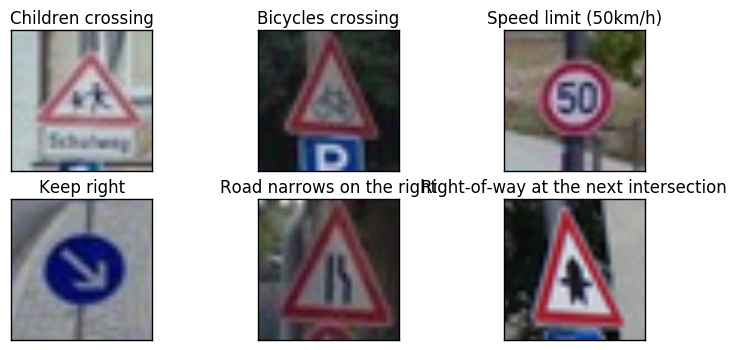

In [365]:
# Image import
img_1 = image.imread('kidsPNG.png')
img_2 = image.imread('bikePNG.png')
img_3 = image.imread('50PNG.png')
img_4 = image.imread('rightPNG.png')
img_5 = image.imread('smallPNG.png')
img_6 = image.imread('rsz_priority.PNG')
img_6 = img_6[:,:,0:3]
X_custom = np.array((img_1,img_2, img_3, img_4, img_5, img_6))

# Associated labels
y_custom = np.array([28, 29, 2, 38, 24, 11])

# Plot
plot_sign_array(X_custom, y_custom, n_height = 2, n_width = 3, indexes = range(6), cmap = 'gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

- Children crossing: The image is quite squashed horizontally and a second unknown traffic sign is added below.
- Bycycle crossing: A part of a parking sign is present below the main traffic sign.
- Speed limit 50: Regular sign
- Keep right: The white circle usually visible in the training set is not visible on this image.
- Road narrows: Regular sign
- Right-of-way: Image taken from an odd angle

In [368]:
# Preprocessing of the images and labels
X_custom_pre = preprocess(X_custom)
y_custom_pre = encoder.transform(y_custom)
y_custom_pre = y_custom_pre.astype(np.float32)

# Prediction
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    custom_accuracy = evaluate(X_custom_pre, y_custom_pre, sess, 1)
    print("Custom Accuracy = ", custom_accuracy)

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


Custom Accuracy =  0.833333333333


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model is able to classify 5 out of the 6 provided images accurately. This results in an accuracy of 83.3%, which is a slight decrease with respect to the test accuracy seen previously. However, this decrease is not really relevant as the size of the data set over which it is computed is much too small.

In [386]:
def top_5_pred(logits):
    p = tf.nn.softmax(logits)
    return tf.nn.top_k(p, k=5)

In [396]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_5 = np.zeros((6, 5))
top_5_ind = np.zeros((6, 5))
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for i in range(6):
        p = sess.run(top_5_pred(logits), feed_dict = {x : X_custom_pre[i].reshape(1,32,32,1),
                                                            y : y_custom_pre[i].reshape(1,43), 
                                                            keep_prob : False}) 
        top_5[i,:] = p.values
        top_5_ind[i,:] = p.indices

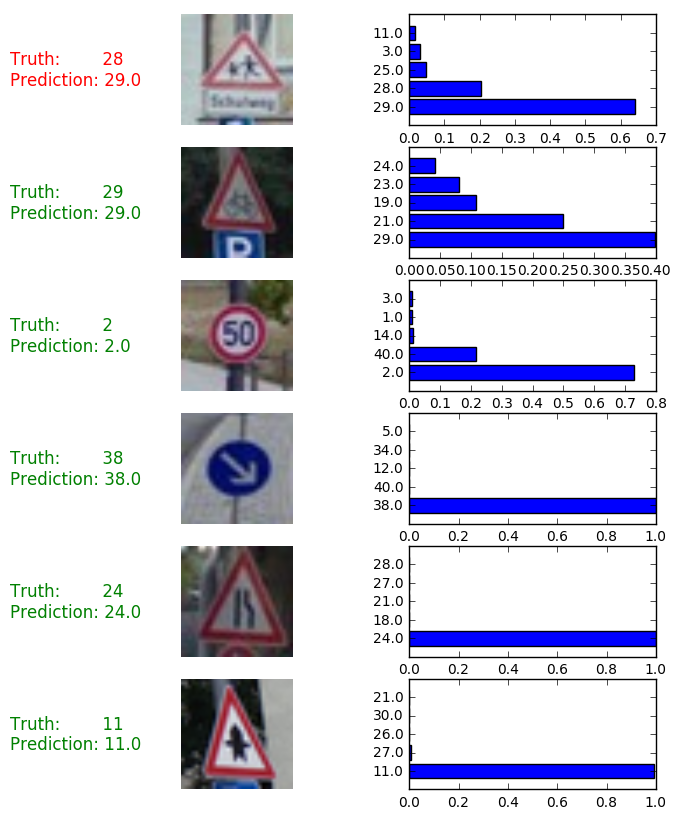

In [459]:
fig = plt.figure(figsize=(7, 10))
for i in range(6):
    # Plot image
    plt.subplot(6, 2,2*i+1)
    
    # Plot correct label
    truth = y_custom[i]
    prediction = top_5_ind[i,np.argmax(top_5[i])]
    color='green' if truth  == prediction else 'red'
    plt.text(-50, 20, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), fontsize=12, color=color)
    
    plt.axis('off')
    plt.imshow(X_custom[i].reshape(32,32,3))
    
    # Plot probabilities
    plt.subplot(6, 2,2*i+2)
    plt.barh(range(5),top_5[i], align='center', tick_label = top_5_ind[i])
    
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**


- Sign 1: The model predicted this sign as a bycicle crossing instead of a pedestrian crossing. Firstly, it is interesting to see that the model still outputs a warning sign. An automonous vehicle using this prediction will therefore still act carefully around this point, even if he it might be expecting cyclists instead of pedestrians. It should also be noted that the correct label was actually the second to be predicted.

- Sign 2 and 3: The predictions are correct and with good levels of confidence.

- Sign 4, 5 and 6: The predictions are correct and the model is entirely sure of its prediction.

All in all, I am very pleased with the generalisation capabilities of the model and the certainty of its predictions. One should note that in practice, sporadic wrong dectections have also less effect on the control algorithms. Indeed, similarly to our lane detection algorithm, sign detections are not done considering a single frame of a video. The detections in several consecutive frames are grouped and fed to tracking algorithms, providing the car with less noisy information about its environment. Therefore, if a sign is not classified correctly along a certain angle or at a certain distance, chances are it will be detected several frames after or that is was already detected previously. The lacking information for that single frame is then filled with the information that was available previously.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Confusion matrix

A useful tool to assess the performance of a classifier is the confusion matrix. It represents how all the data for a given label was was classfied by the model. They plot all the predictions that were made for the data with a given label and how those predicitons were spread amongts the different classes. Therefore, they show us which classes a classifier tends to confuse with one another.

In [463]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    out_train = sess.run(predict, feed_dict={x: X_train_pre.reshape(39209, 32, 32, 1), y: y_train_pre, keep_prob: False})
    out_test  = sess.run(predict, feed_dict={x: X_test_pre.reshape(n_test, 32, 32, 1),  y: y_test_pre,  keep_prob: False})

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [464]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Normalisation for a given class
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1)
    
    # Plot image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set ticks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    # Labels
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1 score on training set =  0.997286685597
F1 score on testing set =  0.96530018246


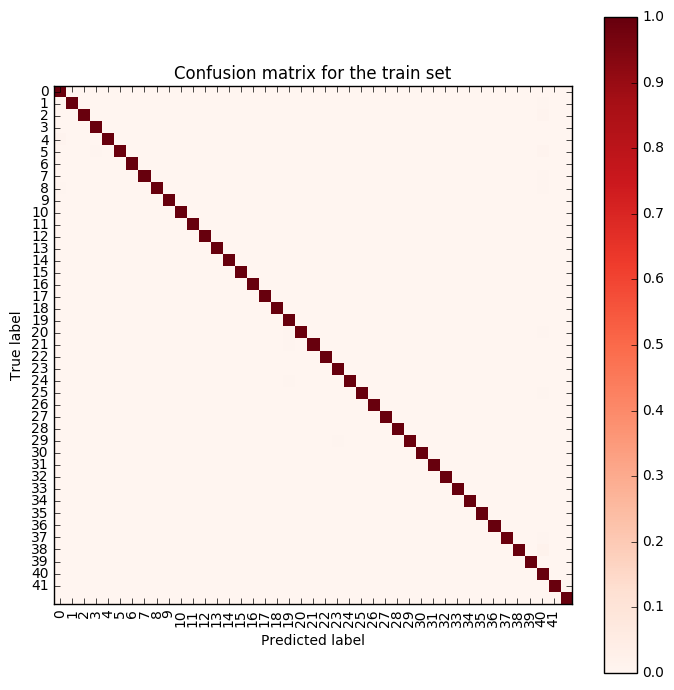

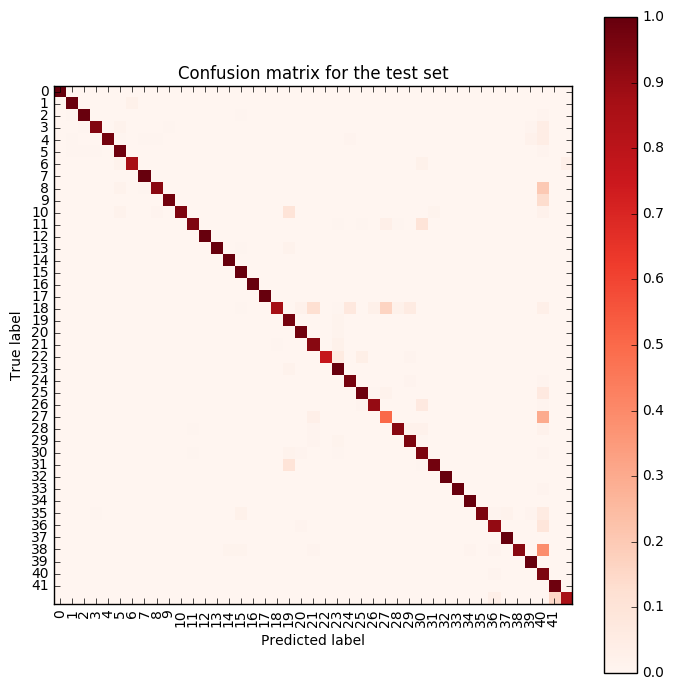

In [465]:
confusion_train = metrics.confusion_matrix(np.argmax(y_train_pre, 1), out_train)
confusion_test  = metrics.confusion_matrix(np.argmax(y_test_pre,  1), out_test )

f1_train = metrics.f1_score(np.argmax(y_train_pre, 1), out_train, average='weighted')
f1_test  = metrics.f1_score(np.argmax(y_test_pre,  1), out_test,  average='weighted')

print('F1 score on training set = ', f1_train)
print('F1 score on testing set = ', f1_test)

matrix_size = 7

plt.figure(figsize=(matrix_size,matrix_size))
plot_confusion_matrix(confusion_train, classes=range(42), title='Confusion matrix for the train set')
plt.show()

plt.figure(figsize=(matrix_size,matrix_size))
plot_confusion_matrix(confusion_test, classes=range(42), title='Confusion matrix for the test set')
plt.show()

One may observe that the matrix computed over the training data is nearly a fully diagonal matrix, showing that the classier is able to well represent the training data. However, it is important for our classifier to keep good performance over data sets its hasn't seen yet. Therefore, the confusion matrix over the test data is plotted as well. After carefull training of the model, one observes a matrix that is quite diagonal as well. However, more points of the diagonal indicate a small decrease in accuracy. The information showed by this plot was actually more useful when the classifier obtained smaller accuracy scores, since it shows us which classes still needs to be worked on to improve the overall accuracy.